In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import math
from datetime import datetime
from datetime import timedelta

import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

import warnings
warnings.filterwarnings("ignore")


In [2]:
pd.options.display.max_columns=100

In [3]:
df_store = pd.read_csv(r'C:\Users\HDIT_03\Downloads\PYTHON\Data portfolio\Walmart Sales Prediction\stores.csv')

In [4]:
df_train = pd.read_csv(r'C:\Users\HDIT_03\Downloads\PYTHON\Data portfolio\Walmart Sales Prediction\train.csv')

In [5]:
df_features = pd.read_csv(r'C:\Users\HDIT_03\Downloads\PYTHON\Data portfolio\Walmart Sales Prediction\features.csv')

In [6]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Merging 3 different set

In [9]:
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [10]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column
df.head() # last ready data set


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [11]:
df.shape

(421570, 16)

Store and Department number

In [12]:
df['Store'].nunique()


45

In [13]:
df['Dept'].nunique()

81

Look at the average weekly sales for each store and each department to see if there is any weird values or not

In [14]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

In [15]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [16]:
df = df.loc[df['Weekly_Sales'] > 0]
df.shape


(420212, 16)

In [17]:
df['Date'].head(5)._append(df['Date'].tail(5)) # to see first and last 5 rows.


0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

IsHoliday Column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

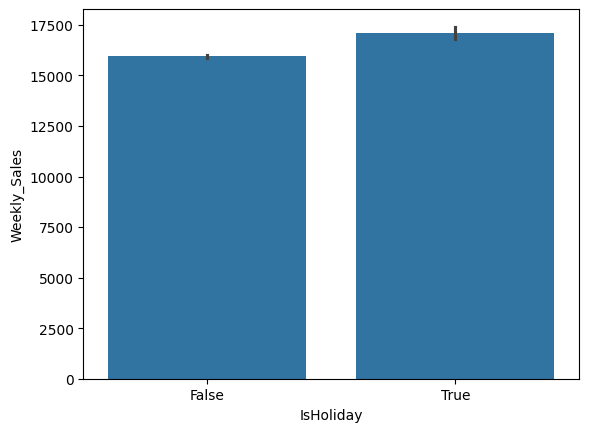

In [18]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [19]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [20]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

In [21]:
#If true then set holiday name
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

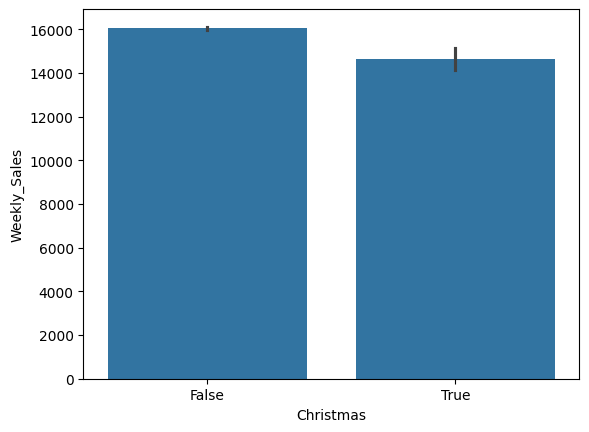

In [22]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas


<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

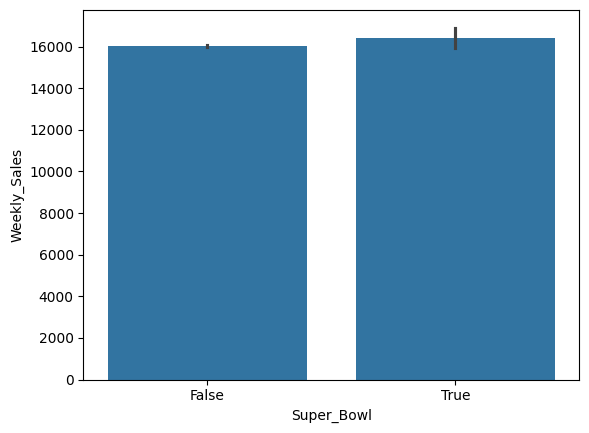

In [23]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

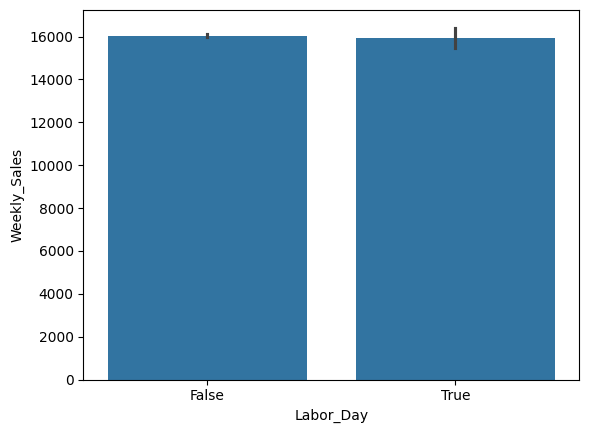

In [24]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

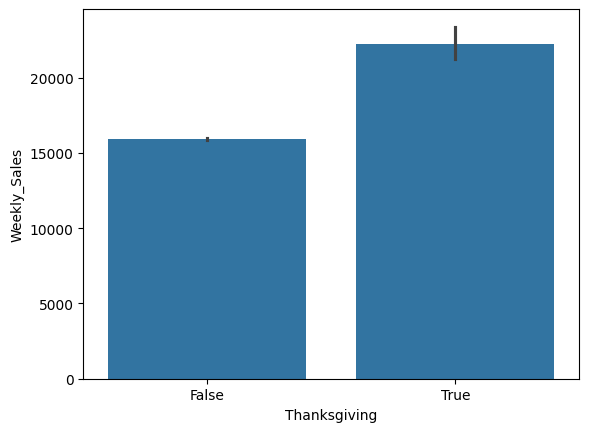

In [25]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

 There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

In [26]:
data_A = df.groupby(['Christmas', 'Type']).agg({'Weekly_Sales' : 'mean'}).reset_index()
A = data_A[data_A['Christmas'] == True]

In [27]:
data_B = df.groupby(['Labor_Day', 'Type']).agg({'Weekly_Sales' : 'mean'}).reset_index()
B = data_B[data_B['Labor_Day'] == True]


In [28]:
data_C = df.groupby(['Thanksgiving', 'Type']).agg({'Weekly_Sales' : 'mean'}).reset_index()
C = data_C[data_C['Thanksgiving'] == True]
C

,Thanksgiving,Type,Weekly_Sales
3,True,A,27397.776346
4,True,B,18733.973971
5,True,C,9696.566616


In [29]:
data_D = df.groupby(['Super_Bowl', 'Type']).agg({'Weekly_Sales' : 'mean'}).reset_index()
D= data_D[data_D['Super_Bowl'] == True]
D

,Super_Bowl,Type,Weekly_Sales
3,True,A,20612.757674
4,True,B,12467.035506
5,True,C,10179.271884


Percentage of Store types

In [30]:
cal = round((df['Type'].value_counts()/df.shape[0])*100,2)
my_data = cal.tolist()
my_label = cal.index



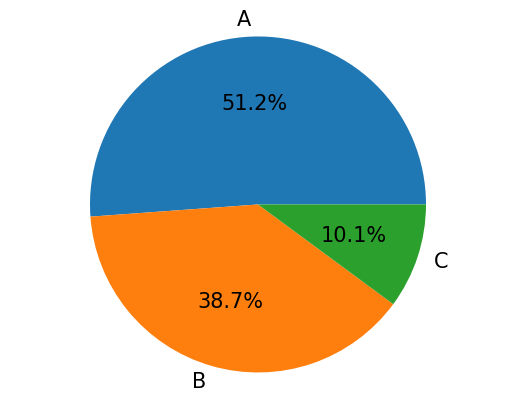

In [31]:
plt.pie(my_data, labels = my_label, autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels
plt.show()
#Half of the store belongs to type A

In [32]:
df.groupby('IsHoliday').agg({'Weekly_Sales' : 'mean'})
#Weekly Sales increase in Holiday

,Weekly_Sales
IsHoliday,
False,15952.816352
True,17094.300918


In [33]:
A._append(B)

,Christmas,Type,Weekly_Sales,Labor_Day
3,True,A,18310.167535,NaN
4,True,B,11488.988057,NaN
5,True,C,8031.520607,NaN
3,NaN,A,20004.267422,True
4,NaN,B,12084.304642,True
5,NaN,C,9893.459258,True


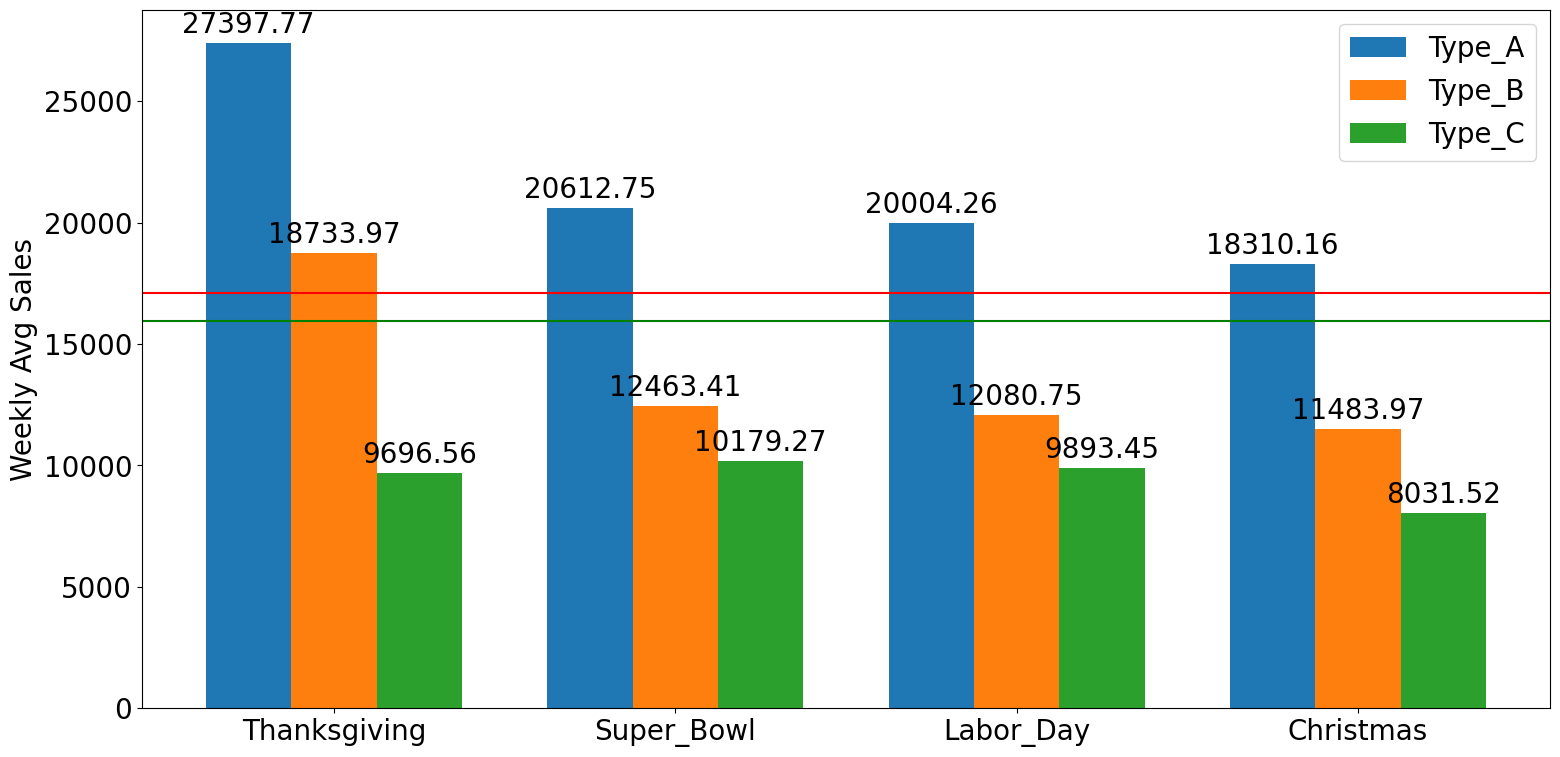

In [34]:
# Plotting avg wekkly sales according to holidays by types
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

To see the Size - Type Relation

In [35]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


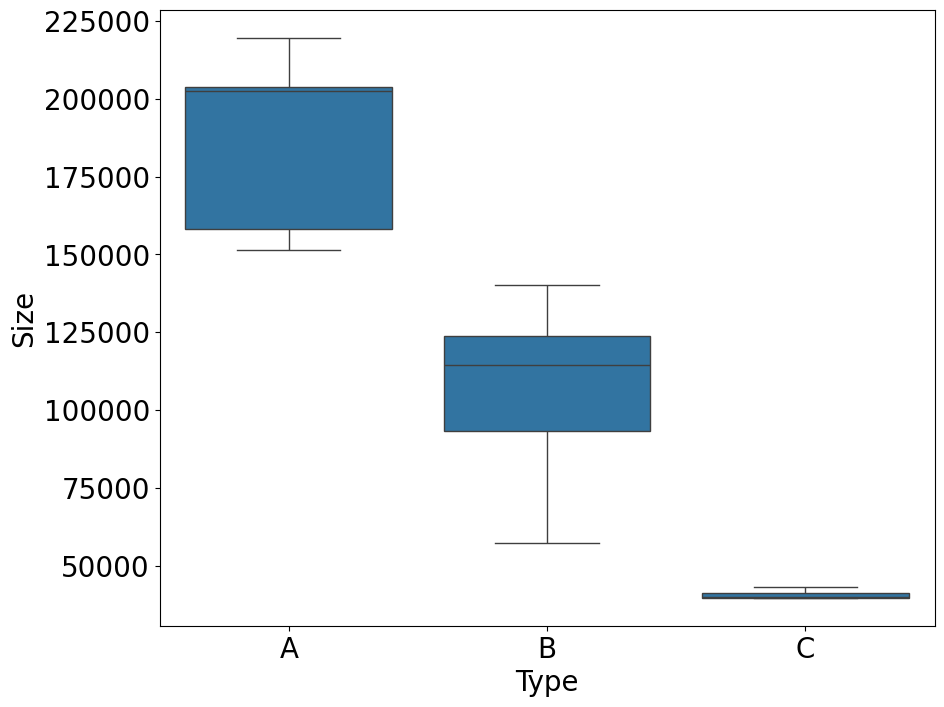

In [36]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

In [37]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [297]:
df = df.fillna(0)

In [298]:
df.isna().sum() # last null check


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [299]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Deeper Look in Sales

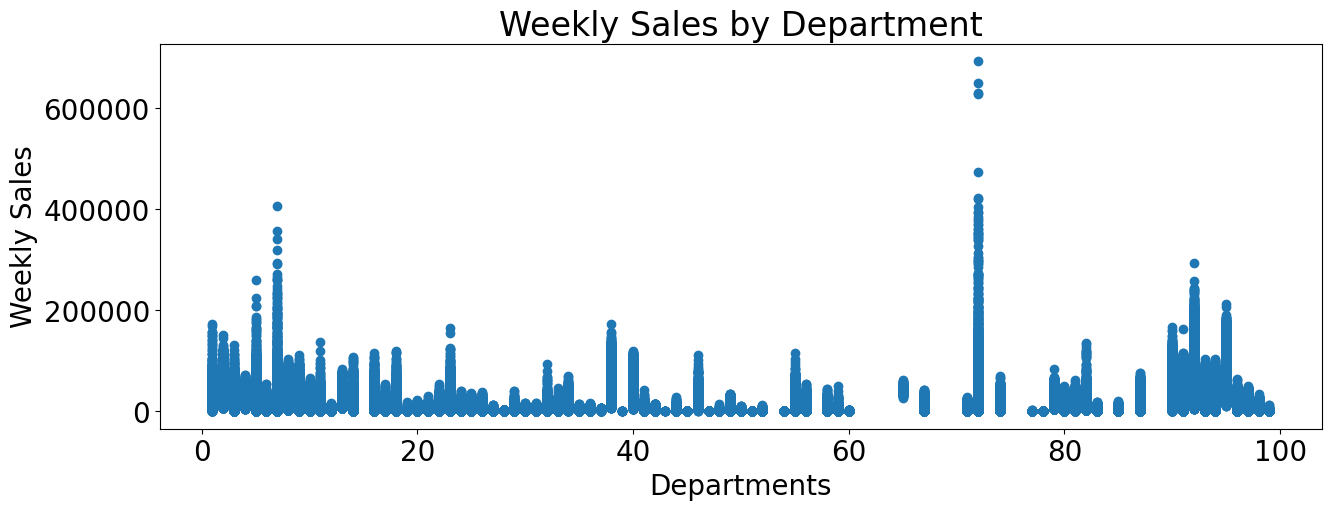

In [300]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

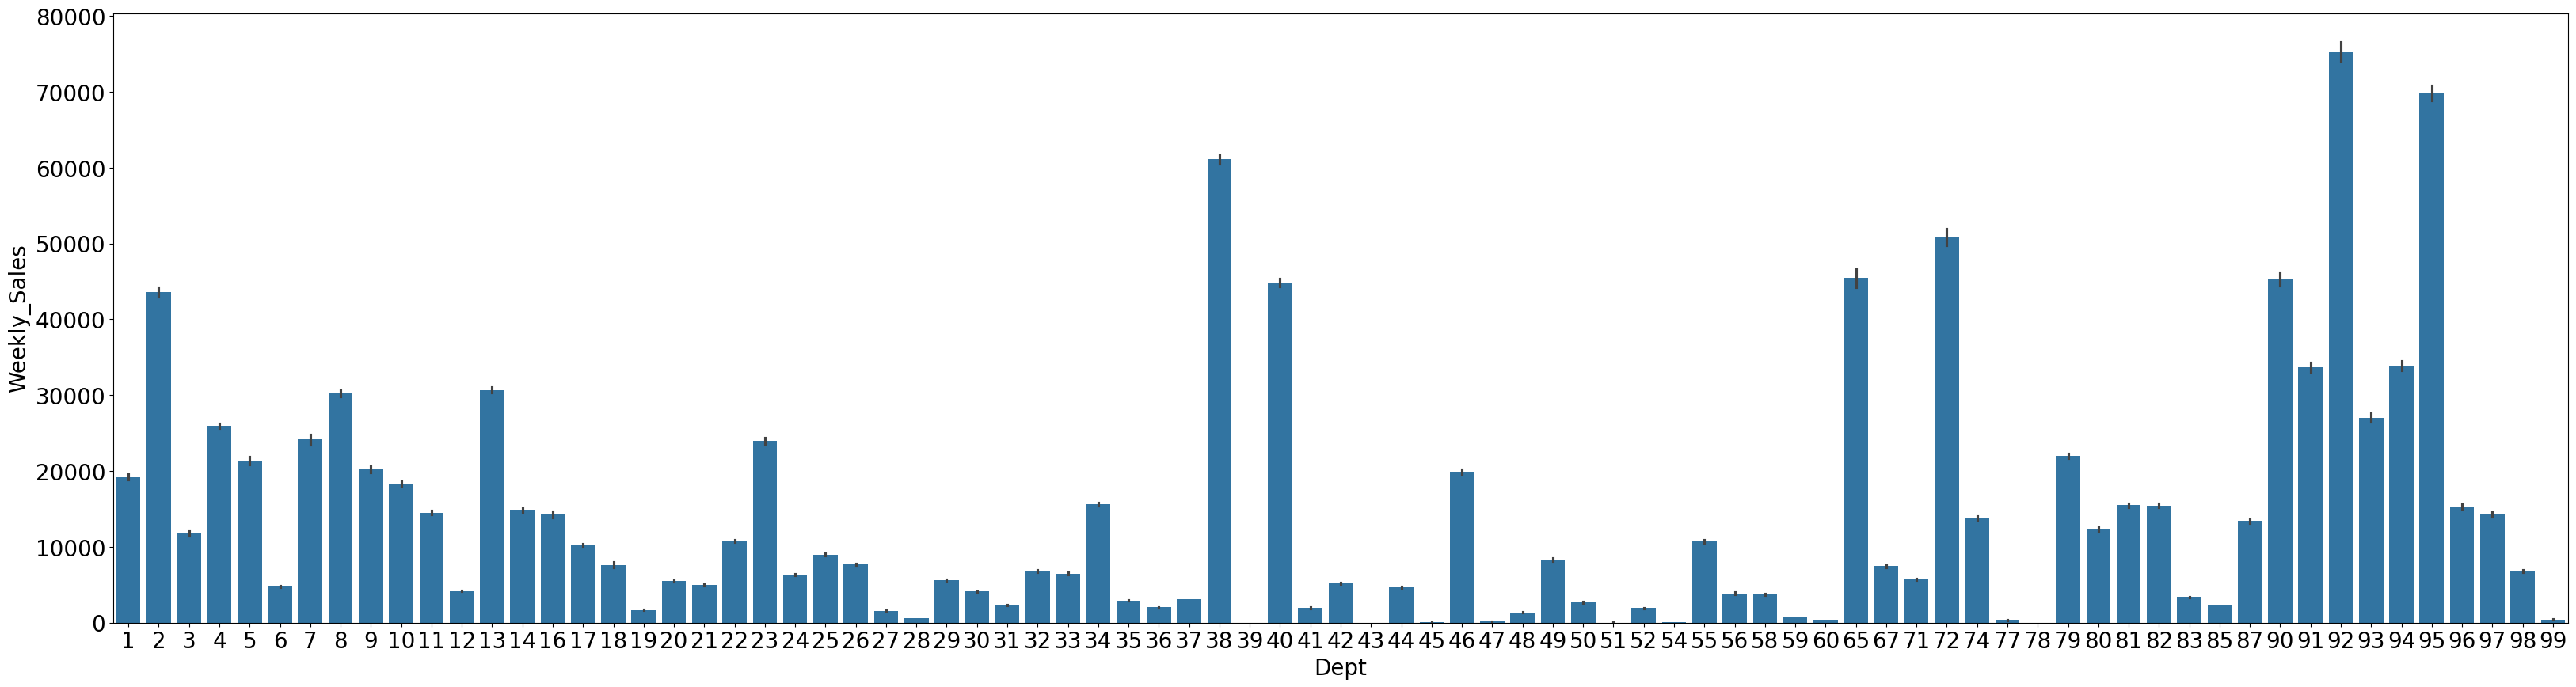

In [301]:
plt.figure(figsize=(40,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

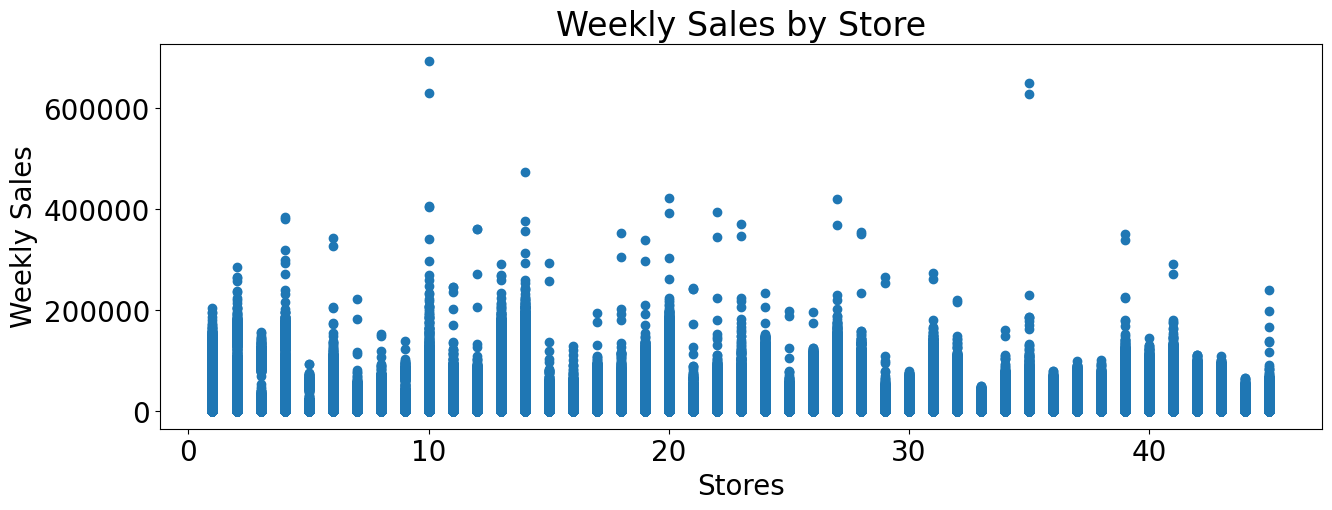

In [302]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

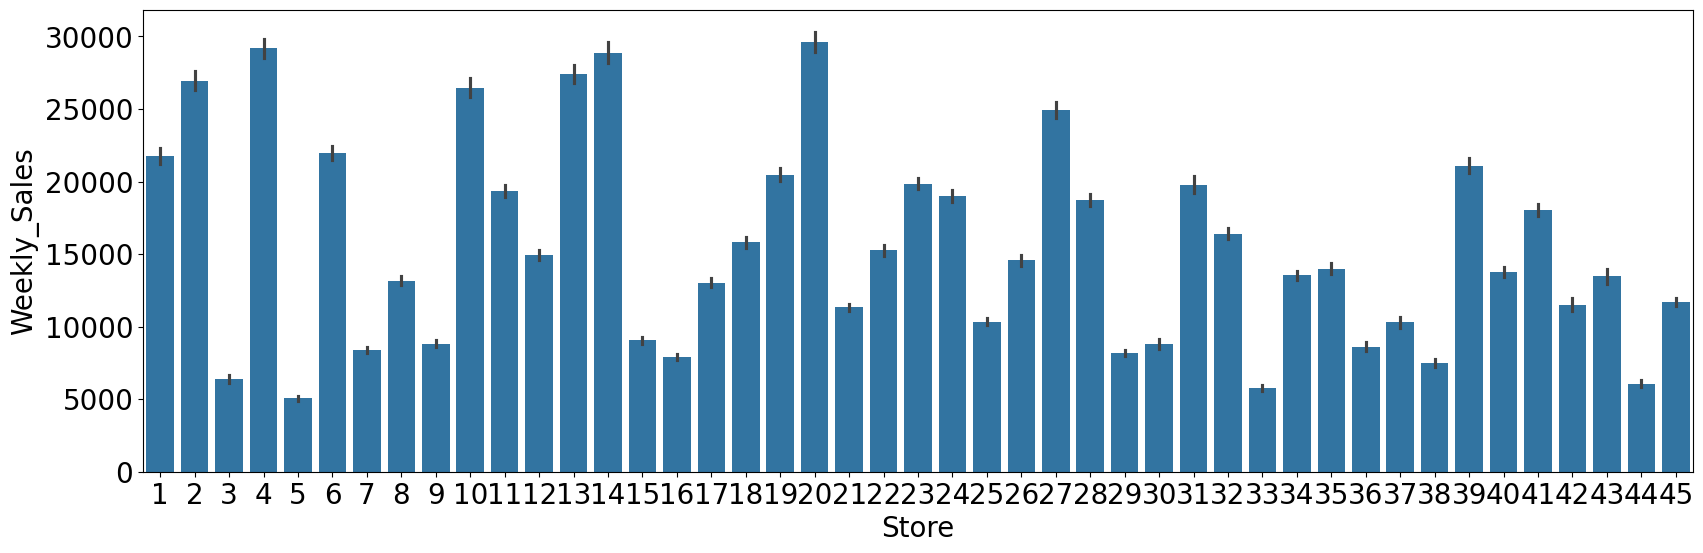

In [303]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Changing Date to Datetime and Creating New Columns

In [304]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [305]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales


month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


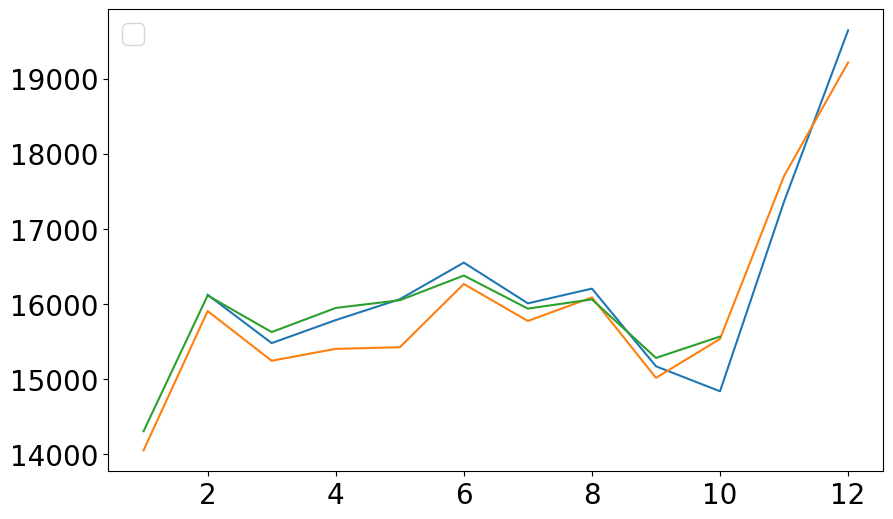

In [306]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales)
plt.legend()

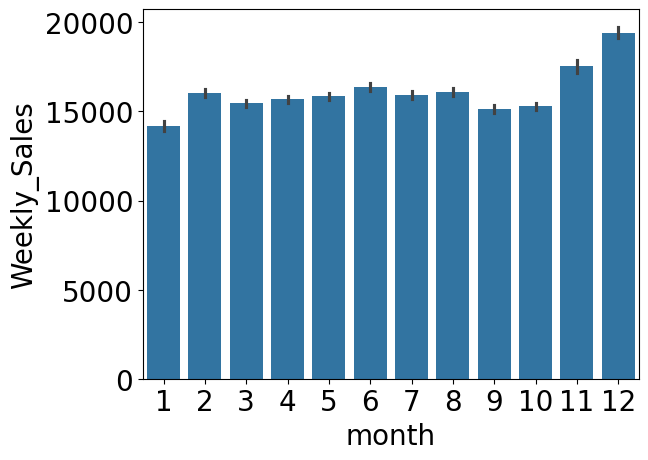

In [307]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

Fuel Price, CPI, Unemployment, Temperature Effect

<Axes: xlabel='Fuel_Price'>

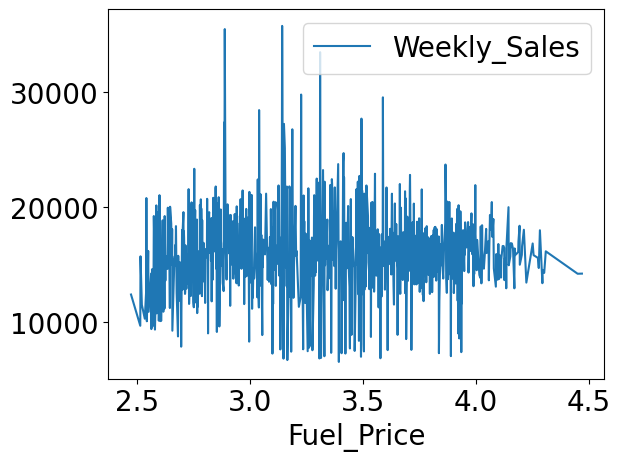

In [308]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

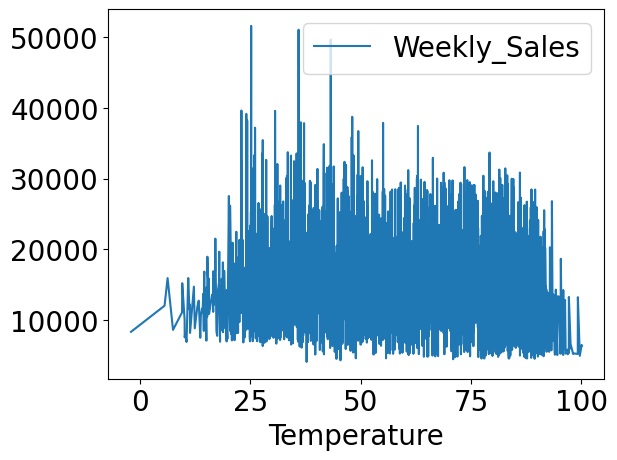

In [309]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

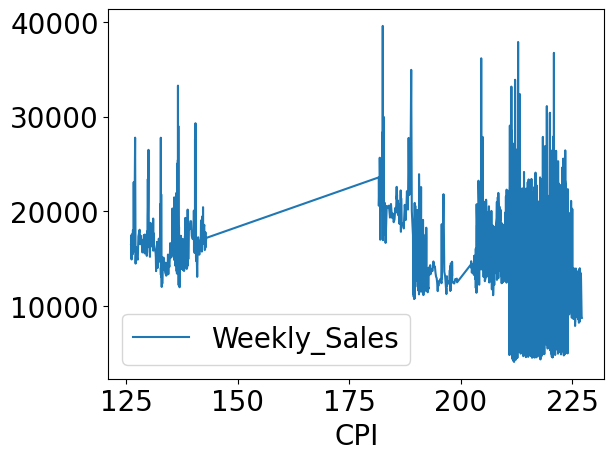

In [310]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

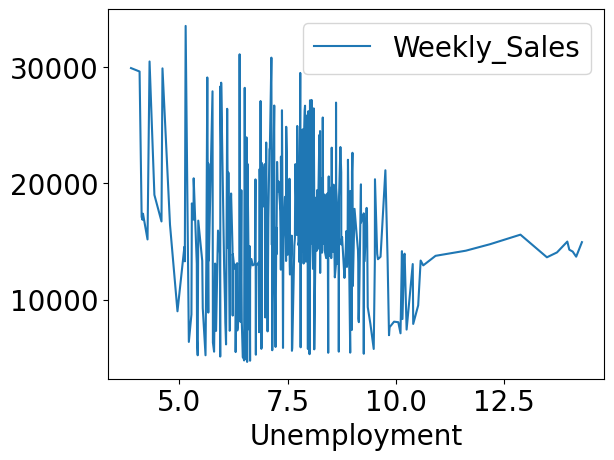

In [311]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

In [312]:
Corr = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']]
Corr_matrix = Corr.corr()
Correlation_with_Weekly_Sales = Corr_matrix['Weekly_Sales']
Correlation_with_Weekly_Sales

Temperature    -0.002339
Fuel_Price      0.000089
CPI            -0.021162
Unemployment   -0.025806
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

In [313]:
df.to_csv('clean_data.csv')

In [314]:
pd.options.display.max_columns=100 # to see columns 

In [315]:
df = pd.read_csv(r'C:\Users\HDIT_03\Downloads\PYTHON\Data portfolio\Walmart Sales Prediction\clean_data.csv')

In [316]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [317]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

Encoding the Data

In [318]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [319]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [320]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [321]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [322]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [323]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [324]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [325]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

Observation of Interaction between feature

In [326]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

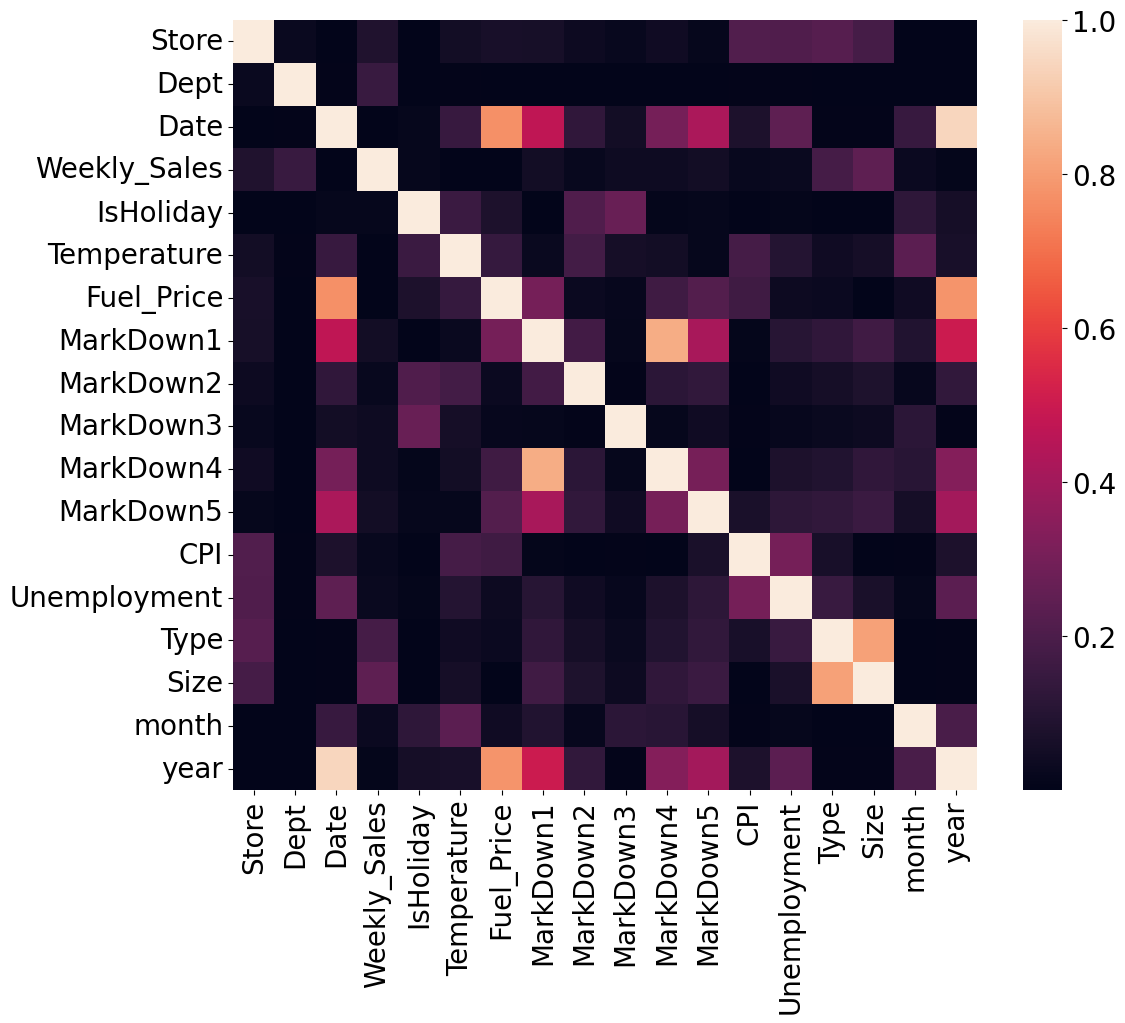

In [327]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

In [328]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

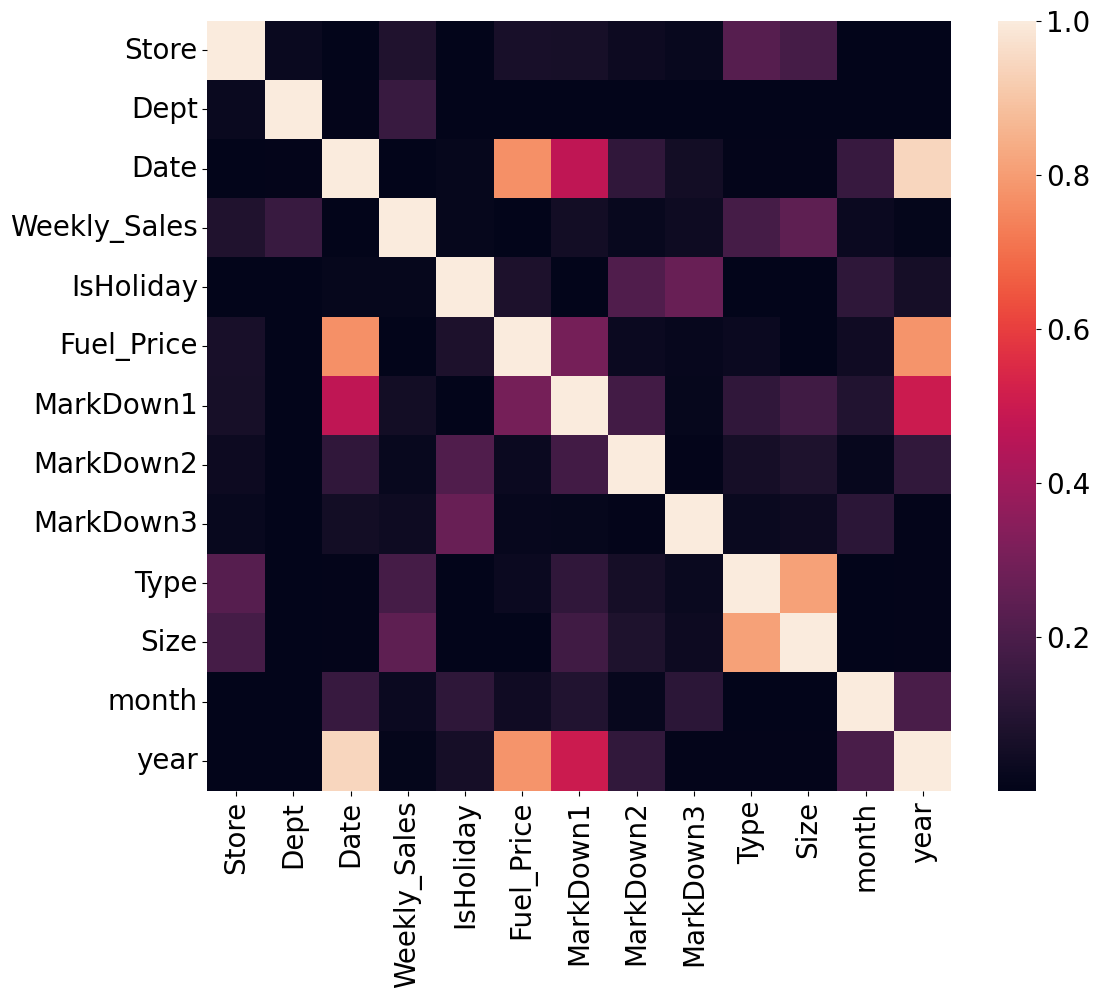

In [329]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

In [330]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

Creating Train - Test Split

In [331]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [332]:
X = df_new[used_cols] # to keep train and test X values together

In [333]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

Matrix definition function

In [334]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [335]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [336]:
wmae_test(y_test, y_pred_test)

5495.163034530042